# analysis

In [246]:
# imports and connect to postgresql
import os, pandas as pd, psycopg2
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from jupyter_dash import JupyterDash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output

conn = psycopg2.connect("dbname=iowaalcohol user=bhrdwj")
cur = conn.cursor()

## eda

### Tables overview

In [ ]:
# List tables in database iowaalcohol
pd.read_sql("""SELECT table_schema || '.' || table_name
    FROM information_schema.tables
    WHERE table_type = 'BASE TABLE'
    AND table_schema NOT IN ('pg_catalog', 'information_schema');""", conn)

In [ ]:
# List columns in table iowaalcohol
data_types = pd.read_sql(
    """SELECT column_name, data_type 
    FROM information_schema.columns
    WHERE table_name = 'iowaalcohol';""", conn)
data_types

In [ ]:
# get null_count
column_names = data_types.column_name.tolist()
query_list = [f"    COUNT(*)-COUNT({i}) as {i}" for i in column_names]
query_string = ',\n    '.join(query_list)
sql = (f"""
SELECT
{query_string}
FROM iowaalcohol; 
""")

null_count = pd.read_sql(sql, conn).T

In [ ]:
null_count

##### Compare revenue and cost per-bottle with "sales" per-bottle

Confirm that (state_btl_retail * btls_sold) is approximately equal to sale_ttl_usd.

In [249]:
revenue_by_county = pd.read_sql("""
    SELECT
        county,
        SUM(state_btl_retail*btls_sold) retail_rev, 
        SUM(state_btl_cost*btls_sold) cost_ogs, 
        SUM(sale_ttl_usd) sale_ttl_usd
    FROM iowaalcohol
    GROUP BY county
    ;""", conn).set_index('county')

In [ ]:
(revenue_by_county//1000000).sort_values('sale_ttl_usd', ascending=False).head(10)

- Observations:
    - (state_btl_retail * btls_sold) largely matches up with sale_ttl_usd
    - There are some irregularities in Polk county
- Deductions:
    - I should use county number instead of county name, and/or lowercase county.
    - I should follow up aggregate anomalies like in Polk county to see:
        - whether they come from a particular year or region etc.
        - why the anomaly shows up with uppercase "POLK" more than "Polk"
    - For now, let's use the cleaned version of county: county_99

## Viz

### Revenue by county, Revenue per capita by county

###### Check cleaned revenue data 

In [251]:
revenue_by_county_99 = pd.read_sql("""SELECT 
    county_99,
    SUM(state_btl_retail*btls_sold) retail_rev, 
    SUM(state_btl_cost*btls_sold) cost_ogs, 
    SUM(sale_ttl_usd) sale_ttl_usd
    FROM iowaalcohol
    GROUP BY county_99
    ;""", conn).set_index('county_99')

In [ ]:
(revenue_by_county_99//1000000).sort_values('sale_ttl_usd', ascending=False).head(3)

##### Visualize revenue by county over 5 years

In [334]:
revenue_by_county_year = pd.read_sql("""
    SELECT 
        county_99,
        DATE_PART('year', date) yeer,
        SUM(sale_ttl_usd) revenue
    FROM iowaalcohol
    GROUP BY county_99, yeer
    ORDER BY county_99, yeer
    ;""", conn)

rbcy_toplot = (revenue_by_county_year
    .set_index(['county_99', 'yeer'])
    .unstack(0).droplevel(0,axis=1)
    )
rbcy_sorted_cols = rbcy_toplot.mean().sort_values(ascending=False).index.tolist()
rbcy_toplot = rbcy_toplot.reindex(rbcy_sorted_cols, axis=1)

In [254]:
revenue_unknown_county = pd.read_sql("""
    SELECT 
        county_99,
        DATE_PART('year', date) yeer,
        SUM(sale_ttl_usd) Unknown_County
    FROM iowaalcohol
    WHERE county_99 = 'UNKNOWN'
    GROUP BY yeer, county_99
    ORDER BY yeer, county_99
    ;""", conn)

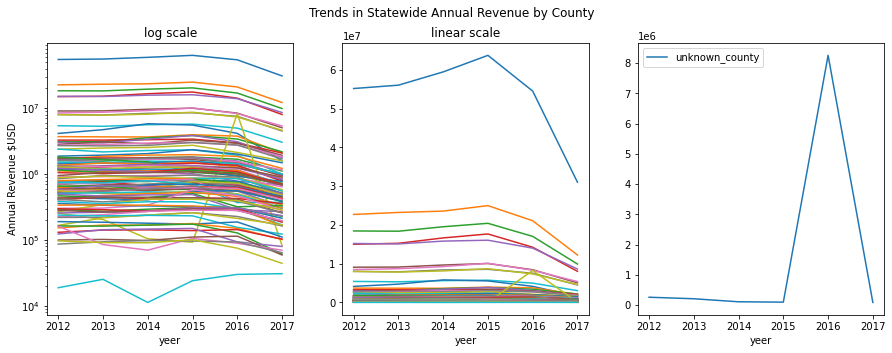

In [329]:
# plot Trends in Statewide Annual Revenue by County
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(15,5))
rbcy_toplot.plot(legend=False, ax=ax0)
rbcy_toplot.plot(legend=False, ax=ax1)
revenue_unknown_county.set_index('yeer').plot(ax=ax2)
ax0.set_yscale('log')
ax0.set_ylabel('Annual Revenue $USD')
ax0.set_title('log scale')
ax1.set_title('linear scale')

plt.suptitle('Trends in Statewide Annual Revenue by County')
plt.show()

In [354]:
rbcy_toplot

county_99,polk,linn,scott,johnson,black hawk,pottawattamie,woodbury,story,dubuque,cerro gordo,...,van buren,decatur,audubon,ringgold,keokuk,taylor,wayne,davis,adams,fremont
yeer,,,,,,,,,,,,,,,,,,,,,
2012.0,55190112.10,22717019.55,18456818.97,15031775.38,15216821.80,9098306.49,8502715.94,8029406.39,8007198.95,5434307.18,...,189865.97,152663.26,163577.03,130629.48,123192.69,99613.74,161736.16,86467.15,96674.89,18793.59
2013.0,56057048.32,23224587.71,18384930.01,15266328.93,15107130.74,9138901.33,8720322.41,7910476.99,7850343.32,5329229.12,...,185716.51,168167.12,162023.28,141162.23,142893.28,101833.15,85065.15,93660.91,91286.24,25211.40
2014.0,59476777.54,23575832.62,19538877.03,16657159.53,15833551.46,9667883.18,9260145.06,8391239.43,8145792.36,5633811.63,...,179516.67,168284.41,168113.60,142328.97,146252.63,98038.53,70010.95,97975.29,90524.22,11229.36
2015.0,63748122.62,24989946.22,20422368.43,17673297.64,16064552.82,10056843.86,10115238.44,8559325.44,8710159.48,5751979.57,...,174245.69,177470.88,173849.23,138680.81,149560.78,110598.35,105438.35,96185.96,100596.80,24029.55
2016.0,54529157.43,21088920.22,17052264.43,14255250.59,14023188.91,8448306.95,8324114.76,7553817.91,7365138.72,4995862.39,...,187612.68,149568.89,127859.46,143559.15,93633.41,114145.24,89033.38,93263.14,75070.97,29947.61
2017.0,31033373.49,12253686.74,9921419.02,8047171.42,8632143.62,5061601.28,5387746.09,4523108.90,4633025.91,3054378.48,...,110732.75,101592.37,60870.62,102887.30,79529.83,59049.25,69905.57,64030.27,44090.55,30747.91


In [362]:
px.line(rbcy_toplot, 
        line_group='county_99', color='county_99', 
        title='Revenue By County (Log Scale)',
        labels='county_99',
        log_y=True
    )

- There's an overall consistent trend of liquor sales decreasing across the state.
- A few smaller counties have a different trend.
- There was a spike of \$10 million in sales to unknown counties in 2016.  (see below)

##### Check revenue per person

In [342]:
revenue_percap_cty_yr = pd.read_sql("""
    SELECT
        ia.county_99,
        DATE_PART('year', date) yeer,
        SUM(sale_ttl_usd)/MAX(cp.population) rev_percap
    FROM iowaalcohol ia
        JOIN county_pop cp
        ON cp.name = ia.county_99
    WHERE county_99 <> 'UNKNOWN'
    GROUP BY county_99, yeer
    ORDER BY rev_percap, yeer
    ;""", conn)

In [337]:
# get dataframe ready to plot
rbcy_percap_toplot = (revenue_percap_cty_yr
    .set_index(['county_99', 'yeer'])
    .unstack(0).droplevel(0,axis=1)
    )
rbcy_percap_sorted_cols = rbcy_percap_toplot.mean().sort_values(ascending=False).index.tolist()
rbcy_percap_toplot = rbcy_percap_toplot.reindex(rbcy_percap_sorted_cols, axis=1)

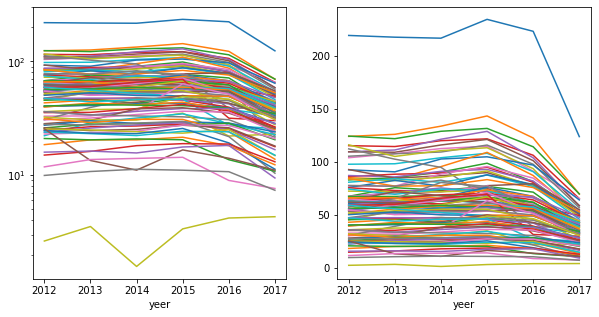

In [343]:
# plot with matplotlib
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,5))
rbcy_percap_toplot.plot(legend=False, ax=ax0)
rbcy_percap_toplot.plot(legend=False, ax=ax1)
ax0.set_yscale('log')

In [375]:
px.line(rbcy_percap_toplot, 
        line_group='county_99', color='county_99', 
        title='Revenue Per Capita By County (Log Scale)',
        labels='county_99',
        log_y=True
    )

### Profit by kind of liquor

In [394]:
data_types

,column_name,data_type
0,state_btl_cost,numeric
1,state_btl_retail,numeric
2,county_number,bigint
3,date,date
4,btls_sold,integer
5,sale_ttl_usd,numeric
6,btl_vol_ml,integer
7,item_no,integer
8,vol_sold_gal,numeric
9,vol_sold_lt,numeric


In [395]:
sql = """
SELECT DISTINCT category_name FROM iowaalcohol;
"""
category_names = pd.read_sql(sql, conn)

In [405]:
print(category_names.sort_values('category_name').category_name.tolist())

['100 PROOF VODKA', '100% Agave Tequila', 'AMARETTO - IMPORTED', 'AMERICAN ALCOHOL', 'AMERICAN AMARETTO', 'AMERICAN COCKTAILS', 'AMERICAN DRY GINS', 'AMERICAN GRAPE BRANDIES', 'AMERICAN SLOE GINS', 'ANISETTE', 'APPLE SCHNAPPS', 'APRICOT BRANDIES', 'Aged Dark Rum', 'American Brandies', 'American Cordials & Liqueur', 'American Cordials & Liqueurs', 'American Distilled Spirit Specialty', 'American Distilled Spirits Specialty', 'American Dry Gins', 'American Flavored Vodka', 'American Gins', 'American Schnapps', 'American Sloe Gins', 'American Vodka', 'American Vodkas', 'BARBADOS RUM', 'BLACKBERRY BRANDIES', 'BLENDED WHISKIES', 'BOTTLED IN BOND BOURBON', 'BUTTERSCOTCH SCHNAPPS', 'Blended Whiskies', 'Bottled in Bond Bourbon', 'CANADIAN WHISKIES', 'CHERRY BRANDIES', 'CINNAMON SCHNAPPS', 'COFFEE LIQUEURS', 'CORN WHISKIES', 'CREAM LIQUEURS', 'CREME DE ALMOND', 'Canadian Whiskies', 'Cocktails / RTD', 'Cocktails /RTD', 'Coffee Liqueurs', 'Corn Whiskies', 'Cream Liqueurs', 'DARK CREME DE CACAO', 

In [413]:
profit_by_kind = pd.read_sql("""
    SELECT
        category_name,
        DATE_PART('year', date) yeer,
        SUM((state_btl_retail - state_btl_cost)*btls_sold) profit
    FROM iowaalcohol
    GROUP BY category_name, yeer
    ORDER BY profit DESC
    ;""", conn)

In [424]:
profit_by_kind_agg = profit_by_kind.groupby('category_name').mean().profit.sort_values(ascending=False)

In [337]:
# get dataframe ready to plot
rbcy_percap_toplot = (revenue_percap_cty_yr
    .set_index(['county_99', 'yeer'])
    .unstack(0).droplevel(0,axis=1)
    )
rbcy_percap_sorted_cols = rbcy_percap_toplot.mean().sort_values(ascending=False).index.tolist()
rbcy_percap_toplot = rbcy_percap_toplot.reindex(rbcy_percap_sorted_cols, axis=1)

In [ ]:
# plot with matplotlib
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,5))
rbcy_percap_toplot.plot(legend=False, ax=ax0)
rbcy_percap_toplot.plot(legend=False, ax=ax1)
ax0.set_yscale('log')

In [ ]:
px.line(rbcy_percap_toplot, 
        line_group='county_99', color='county_99', 
        title='Revenue Per Capita By County (Log Scale)',
        labels='county_99',
        log_y=True
    )